This is based on the tutorial Simoni Thomas: 
https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Doom/Deep%20Q%20learning%20with%20Doom.ipynb

In [26]:
import numpy as np
import vizdoom
import matplotlib.pyplot as plt
import random
import time
from skimage import transform

In [6]:
def create_environment():
    game = vizdoom.DoomGame()
    
    # Load the correct configuration
    game.load_config("basic.cfg")
    
    # Load the correct scenario (in our case basic scenario)
    game.set_doom_scenario_path("basic.wad")
    
    game.init()
    
    # Here our possible actions
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    possible_actions = [left, right, shoot]
    
    return game, possible_actions

Reward: -1.0


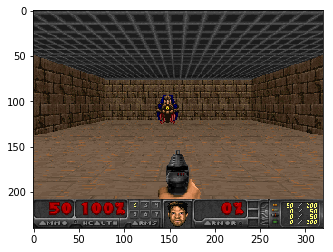

In [12]:
game, actions = create_environment()
game.new_episode()
state = game.get_state()
img = state.screen_buffer
action = [0, 0, 1]
reward = game.make_action(action)
game.close()
print("Reward:", reward)
img = np.moveaxis(img, 0, -1)
plt.imshow(img)

c:\users\stig\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\stig\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


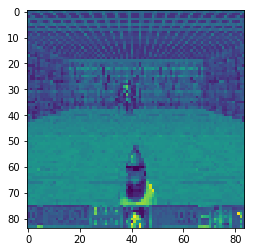

In [30]:
def preprocess_frame(img):
    x = np.mean(img, -1)
    x = x / 255.
    x = x[30:-10,30:-30]
    x = transform.resize(x, [84, 84])
    return x
x = preprocess_frame(img)


